<a href="https://colab.research.google.com/github/czengnn/lana-del-rey-lyrics-generator/blob/main/LDR_by_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, display

def set_css():
    display(HTML('''<style> pre {white-space: pre-wrap;} </style>'''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import matplotlib.pyplot as plt

import tensorflow as tf
import keras 
print(tf.__version__)
print(keras.__version__)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import sparse_categorical_crossentropy

from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint


2.4.1
2.4.3


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# load songs
songs = pd.read_csv('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/data/lana_lyrics_98.csv')
songs.shape

(98, 2)

In [6]:
# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
    
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)

In [7]:
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

Length of text: 161722 characters
61 unique characters


In [8]:
corpus = list(set(text.lower().split('\n')))
corpus[:5]

['',
 'acting like a big shot',
 'high tops in the summer (summer, what? what? what?)',
 "so you'd better believe that nobody can make me feel lonely",
 'and my crooked words']

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)

2575


In [10]:
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)
input_sequences[20:30]

[[33, 308, 203, 432, 17, 309, 45, 66, 6, 68],
 [33, 308, 203, 432, 17, 309, 45, 66, 6, 68, 310],
 [4, 7],
 [4, 7, 1327],
 [4, 7, 1327, 383],
 [87, 6],
 [87, 6, 30],
 [87, 6, 30, 96],
 [87, 6, 30, 96, 12],
 [87, 6, 30, 96, 12, 433]]

In [11]:
# pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding='pre'))

In [12]:
input_sequences[:2]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0, 916,  11],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 916,  11,   8]], dtype=int32)

In [13]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors.shape

(17490, 17)

### Building The Model

In [29]:
from keras import backend as K
K.clear_session()

def sparse_cat_loss(y_true,y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

vocab_size = total_words
embed_dim = 60
def create_model(vocab_size, embed_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_sequence_len-1))

    # Add an LSTM Layer
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    # A dropout layer for regularisation
    model.add(Dropout(0.1))
    # Add another LSTM Layer
    model.add(LSTM(100,return_sequences=False)) 
    model.add(Dropout(0.1))
    model.add(Dense(vocab_size//2, activation='relu'))
    # In the last layer, the shape should be equal to the total number of words present in our corpus
    model.add(Dense(vocab_size, activation='softmax'))
    return model

model = create_model(vocab_size, embed_dim)
model.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 17, 60)            154500    
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 300)           253200    
_________________________________________________________________
dropout (Dropout)            (None, 17, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1287)              129987    
_________________________________________________________________
dense_1 (Dense)              (None, 2575)              3

In [28]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(predictors, label, epochs=100, verbose=1, callbacks=[early_stopping])

# Save the weights
model.save_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word/ldr_by_word')

Epoch 1/200
547/547 [==============================] - 9s 9ms/step - loss: 6.5541 - accuracy: 0.0344
Epoch 2/200
547/547 [==============================] - 5s 9ms/step - loss: 5.9512 - accuracy: 0.0396
Epoch 3/200
547/547 [==============================] - 5s 9ms/step - loss: 5.7013 - accuracy: 0.0465
Epoch 4/200
547/547 [==============================] - 5s 9ms/step - loss: 5.4721 - accuracy: 0.0584
Epoch 5/200
547/547 [==============================] - 5s 9ms/step - loss: 5.2630 - accuracy: 0.0771
Epoch 6/200
547/547 [==============================] - 5s 9ms/step - loss: 5.0738 - accuracy: 0.0977
Epoch 7/200
547/547 [==============================] - 5s 9ms/step - loss: 4.8965 - accuracy: 0.1116
Epoch 8/200
547/547 [==============================] - 5s 9ms/step - loss: 4.7703 - accuracy: 0.1160
Epoch 9/200
547/547 [==============================] - 5s 9ms/step - loss: 4.5595 - accuracy: 0.1327
Epoch 10/200
547/547 [==============================] - 5s 9ms/step - loss: 4.4360 - accura

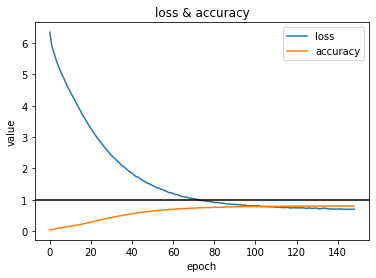

In [21]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.axhline(y=1, color='k')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

#### Recreate the model and load saved weights

In [30]:
# Create a new model instance
model_loaded = create_model(vocab_size, embed_dim)
model_loaded.load_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word/ldr_by_word')
model_loaded.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')

In [31]:
def make_lyrics(model, seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [32]:
predicted_lyrics = make_lyrics(model_loaded, 'james', 100)
print(predicted_lyrics)

james ice creams hours in a good hotel record and use it out in the things that i need it for fun i need somebody to hold me or just say that you were mine i'd be honest capable i'd say i was dead hard down down down down down her little bambi eyes queens style up in my arms just love or feel we'll need it last you can be a bad motherfucker light and star and forever we talk about the black beaches can i get a ball friends do it but it was not hard not to get


In [33]:
predicted_lyrics = make_lyrics(model_loaded, 'ice cream', 100)
print(predicted_lyrics)

ice cream ice queen style cool days up in the garden of evil own again dreamin' about of the first love real love real good for free jesus and time past love me anyway then i was dead know that to say goodbye and i miss you babe and it's makin' me blue and lonely i need somebody to hold me or just say that you were mine capable why just say that you were mine adores you on my lips i do i do best look how i got you where i want you now me why just swallow some wine


In [34]:
predicted_lyrics = make_lyrics(model_loaded, 'james dean', 100)
print(predicted_lyrics)

james dean for sure died than i ever even mind i've been cold without you and i so better off i think of that once i will love you till the end of time or whatever baby you're no good for me and i got your number and you better believe that it's got my escape my nights off my loins friend to me fun but you don't know the half of the shit that you put me through your fingertips mind change everything what what what what what what what what what what yeah was i country girls wanna know that


In [35]:
predicted_lyrics = make_lyrics(model_loaded, 'queen of', 100)
print(predicted_lyrics)

queen of coney island queen of fire and black beaches driving darling i can taste it turnin' sour here from my hands into moonlight row in time i know that i am alone to make me be bittersweet to just be free hey i thought he was breaking 'em down down down tonight yeah oh shatter yeah yeah oh shatter yeah yeah oh shatter i way you got that medicine that me love me that yeah my that to take my thoughts away this kids the last time i think about leaving that and i can't change your mood ah ah ah


In [ ]:
predicted_lyrics = make_lyrics(model_loaded, 'park', 100)
print(predicted_lyrics)

park making me everything's okay ay babe yeah 'bout it from the spring i feel it at your whole world is so always like it like a minute night yeah you blame the news he prays for love he prays for peace and maybe someone new coat on the spring i love track of the right thing to from a woman are hard to wait to me alive again at you do was read do he in the sky with the real that's agree powerful beings hot weather in the spring i me baby we need to start diamonds on a


Test Loaded model

In [26]:
predicted_lyrics = make_lyrics(model_loaded, 'california', 50)
print(predicted_lyrics)

california dreamin' got my name as your tattoo and pearls to call me dn to think about mine in mine mine mine how i got this and vine way it feels like summer mine 'til mine that you would pay tribute day around when mine i'd you work baby i'm wild
